# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                        
Sample_082  A0A087WWF1;Q8WWX9                                                        15.320
Sample_132  G3V533;Q6ZMZ3;Q6ZMZ3-2;Q6ZMZ3-3                                          16.998
Sample_004  E7EN28;E7ESV6;E7ETE3;E7EUP0;E7EUW2;E7EVD6;E7EX52                         16.535
Sample_000  Q6E0U4;Q6E0U4-16;Q6E0U4-2;Q6E0U4-3;Q6E0U4-4;Q6E0U4-5;Q6E0U4-6;Q6E0U4-7   16.572
Sample_162  Q14697;Q14697-2                                                          16.444
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups      
Sample_159  F5GX83;F5H2M3;Q9H3S3   13.012
Sample_093  O14745                 10.400
Sample_111  Q9NQ30                 12.400
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.776
            A0A075B6Q5                 13.466
            A0A075B6R2                 13.258
            A0A075B6S5                 14.550
            A0A087WSY4                 12.984
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.595
            Q9UI40;Q9UI40-2            12.482
            Q9UIW2                     12.805
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.042
            Q9UP79                     14.062
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.709,15.050,16.842,19.863,12.941,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.003,19.067,...,15.528,15.576,12.368,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.810,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,10.037,17.705,17.039,14.781,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.527,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.407,15.345,17.084,18.708,14.249,19.433,8.895,9.787
Sample_207,15.739,16.877,15.469,16.898,14.982,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.535,12.863,12.682,13.067,12.706,12.022,13.687,13.499,11.974,12.352
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.699,19.067,16.127,...,12.867,13.070,13.475,12.726,13.389,12.320,12.645,12.602,12.998,12.822
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.072,12.112,13.174,12.658,10.710,12.356,12.943,12.173,12.937,12.888
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.088,11.986,12.015,13.597,11.530,13.239,14.141,12.991,12.948,12.351
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.322,13.002,11.404,14.089,13.011,13.340,12.508,12.620,12.277,12.960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.234,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 391.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.28it/s]

100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.35it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.68it/s]

100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.66it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.27it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.78it/s]

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.47it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.48it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.08it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.20it/s]

100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.05it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.22it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.85it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.52it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.76it/s]

100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  6.00it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.85it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.20it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.02it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.02it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.17it/s]

100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

100%|██████████| 8/8 [00:01<00:00,  4.22it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.82it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.27it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.90it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.82it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.67it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.64it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.52it/s]

100%|██████████| 9/9 [00:01<00:00,  4.38it/s]

100%|██████████| 9/9 [00:01<00:00,  4.71it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.08it/s]

 30%|███       | 3/10 [00:00<00:01,  6.08it/s]

 40%|████      | 4/10 [00:00<00:01,  5.34it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.92it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.83it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.64it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.59it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.31it/s]

100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

100%|██████████| 10/10 [00:02<00:00,  4.73it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.03it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.15it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.53it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.16it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.70it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.79it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.48it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.31it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.34it/s]

100%|██████████| 11/11 [00:02<00:00,  3.00it/s]

100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.56it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.67it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.24it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.08it/s]

 50%|█████     | 6/12 [00:01<00:01,  5.00it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.65it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.86it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.46it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.20it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  2.81it/s]

100%|██████████| 12/12 [00:03<00:00,  2.76it/s]

100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.62it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.74it/s]

 31%|███       | 4/13 [00:00<00:01,  5.79it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.41it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.93it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.30it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.78it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.66it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.41it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.14it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.99it/s]

100%|██████████| 13/13 [00:03<00:00,  2.88it/s]

100%|██████████| 13/13 [00:03<00:00,  3.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.87it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.27it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.33it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.77it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.65it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.11it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.63it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.44it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.39it/s]

 79%|███████▊  | 11/14 [00:02<00:01,  2.98it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.89it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.64it/s]

100%|██████████| 14/14 [00:04<00:00,  2.67it/s]

100%|██████████| 14/14 [00:04<00:00,  3.44it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.77it/s]

 20%|██        | 3/15 [00:00<00:01,  6.39it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.32it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.08it/s]

 40%|████      | 6/15 [00:01<00:01,  4.90it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.86it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.84it/s]

 60%|██████    | 9/15 [00:01<00:01,  3.79it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.18it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  2.87it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.64it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.50it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.47it/s]

100%|██████████| 15/15 [00:04<00:00,  2.41it/s]

100%|██████████| 15/15 [00:04<00:00,  3.30it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.051 0.024          0.619 0.426       0.085   
2             0.004 0.002      0.044 0.015          0.633 0.142       0.371   
3             0.007 0.006      0.059 0.023          0.663 0.099       0.542   
4             0.004 0.002      0.039 0.011          0.777 0.097       0.736   
5             0.004 0.003      0.040 0.014          0.760 0.093       0.758   
6             0.003 0.000      0.036 0.009          0.778 0.091       0.789   
7             0.004 0.002      0.044 0.018          0.803 0.079       0.800   
8             0.006 0.005      0.057 0.021          0.809 0.077       0.802   
9             0.006 0.005      0.060 0.025          0.802 0.086       0.803   
10            0.007 0.006      0.067 0.023          0.792 0.073       0.804   
11            0.006 0.005      0.058 0.025          0.790 0.073       0.799   
12            0.005 0.004      0.055 0.022          0.789 0.078       0.800   
13            0.005 0.005      0.055 0.027          0.787 0.076       0.794   
14            0.005 0.004      0.052 0.025          0.798 0.087       0.795   
15            0.005 0.006      0.052 0.021          0.791 0.090       0.792   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.143 0.125                  0.535 0.037        0.849   
2          0.114   0.454 0.106                  0.601 0.061        0.689   
3          0.099   0.589 0.080                  0.666 0.058        0.714   
4          0.100   0.752 0.079                  0.789 0.066        0.881   
5          0.091   0.755 0.074                  0.789 0.064        0.883   
6          0.100   0.779 0.074                  0.810 0.063        0.888   
7          0.102   0.797 0.070                  0.827 0.058        0.906   
8          0.097   0.802 0.066                  0.831 0.055        0.906   
9          0.094   0.798 0.066                  0.827 0.057        0.908   
10         0.092   0.795 0.064                  0.824 0.054        0.909   
11         0.094   0.791 0.065                  0.822 0.056        0.906   
12         0.096   0.791 0.070                  0.821 0.059        0.905   
13         0.096   0.787 0.069                  0.818 0.059        0.904   
14         0.097   0.792 0.073                  0.822 0.062        0.908   
15         0.096   0.787 0.075                  0.818 0.063        0.906   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.818 0.085        210.000 0.000  
2          0.084                  0.627 0.097        210.000 0.000  
3          0.071                  0.665 0.086        210.000 0.000  
4          0.056                  0.845 0.074        210.000 0.000  
5          0.052                  0.851 0.066        210.000 0.000  
6          0.050                  0.854 0.065        210.000 0.000  
7          0.046                  0.885 0.052        210.000 0.000  
8          0.047                  0.886 0.051        210.000 0.000  
9          0.045                  0.894 0.047        210.000 0.000  
10         0.044                  0.897 0.044        210.000 0.000  
11         0.045                  0.894 0.046        210.000 0.000  
12         0.046                  0.892 0.048        210.000 0.000  
13         0.047                  0.890 0.049        210.000 0.000  
14         0.046                  0.897 0.048        210.000 0.000  
15         0.047                  0.895 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 521.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.37it/s]

100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.76it/s]

100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.21it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.39it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.21it/s]

100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.81it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.03it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.50it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.28it/s]

100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.89it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.61it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.80it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.43it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.34it/s]

100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.98it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.07it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.58it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.39it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.42it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.13it/s]

100%|██████████| 8/8 [00:01<00:00,  3.92it/s]

100%|██████████| 8/8 [00:01<00:00,  4.34it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.24it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.51it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.04it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.86it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.70it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.75it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.84it/s]

100%|██████████| 9/9 [00:02<00:00,  3.88it/s]

100%|██████████| 9/9 [00:02<00:00,  3.99it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.99it/s]

 30%|███       | 3/10 [00:00<00:01,  5.14it/s]

 40%|████      | 4/10 [00:00<00:01,  4.44it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.13it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.86it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.33it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.98it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.62it/s]

100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.41it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.61it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.21it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.29it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.47it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.60it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.64it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.69it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.35it/s]

100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

100%|██████████| 11/11 [00:03<00:00,  3.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.06it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.48it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.33it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.97it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.84it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.77it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.72it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.58it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.68it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.85it/s]

100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.75it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.23it/s]

 31%|███       | 4/13 [00:01<00:02,  3.18it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.30it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.33it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.48it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.44it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.36it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.39it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.51it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.95it/s]

100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

100%|██████████| 13/13 [00:04<00:00,  3.17it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.41it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.58it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.83it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.51it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.36it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.17it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.16it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.01it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.06it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.26it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.26it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.17it/s]

100%|██████████| 14/14 [00:05<00:00,  2.23it/s]

100%|██████████| 14/14 [00:05<00:00,  2.35it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.71it/s]

 20%|██        | 3/15 [00:01<00:04,  2.82it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.57it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.48it/s]

 40%|████      | 6/15 [00:02<00:03,  2.38it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.32it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.60it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.91it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.01it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.19it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.21it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.24it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.37it/s]

100%|██████████| 15/15 [00:05<00:00,  3.58it/s]

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.057 0.025          0.756 0.355       0.118   
2             0.004 0.002      0.046 0.021          0.702 0.092       0.605   
3             0.007 0.007      0.068 0.027          0.671 0.098       0.576   
4             0.003 0.000      0.036 0.008          0.735 0.099       0.615   
5             0.004 0.003      0.058 0.026          0.717 0.097       0.632   
6             0.003 0.000      0.038 0.010          0.706 0.109       0.642   
7             0.003 0.001      0.037 0.009          0.796 0.106       0.735   
8             0.003 0.000      0.039 0.019          0.797 0.101       0.734   
9             0.007 0.006      0.069 0.019          0.796 0.105       0.734   
10            0.003 0.000      0.037 0.008          0.817 0.098       0.782   
11            0.006 0.007      0.048 0.017          0.807 0.094       0.779   
12            0.004 0.005      0.039 0.012          0.808 0.081       0.797   
13            0.005 0.004      0.051 0.024          0.826 0.072       0.810   
14            0.005 0.003      0.054 0.025          0.827 0.078       0.811   
15            0.004 0.002      0.046 0.020          0.817 0.073       0.815   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.196 0.132                  0.551 0.042        0.849   
2          0.106   0.644 0.081                  0.707 0.060        0.783   
3          0.110   0.613 0.085                  0.681 0.063        0.783   
4          0.111   0.663 0.086                  0.724 0.065        0.800   
5          0.103   0.664 0.071                  0.721 0.055        0.813   
6          0.114   0.665 0.084                  0.719 0.067        0.816   
7          0.106   0.757 0.076                  0.794 0.063        0.892   
8          0.110   0.757 0.079                  0.795 0.065        0.890   
9          0.109   0.757 0.079                  0.794 0.065        0.889   
10         0.105   0.793 0.074                  0.824 0.062        0.907   
11         0.113   0.786 0.075                  0.819 0.062        0.905   
12         0.094   0.798 0.063                  0.827 0.053        0.908   
13         0.086   0.815 0.062                  0.842 0.053        0.916   
14         0.080   0.815 0.056                  0.841 0.048        0.918   
15         0.077   0.814 0.057                  0.840 0.050        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.068                  0.760 0.085        210.000 0.000  
3          0.071                  0.745 0.088        210.000 0.000  
4          0.065                  0.767 0.084        210.000 0.000  
5          0.062                  0.783 0.076        210.000 0.000  
6          0.062                  0.780 0.079        210.000 0.000  
7          0.053                  0.880 0.058        210.000 0.000  
8          0.053                  0.878 0.058        210.000 0.000  
9          0.053                  0.876 0.058        210.000 0.000  
10         0.048                  0.889 0.054        210.000 0.000  
11         0.047                  0.889 0.051        210.000 0.000  
12         0.044                  0.890 0.046        210.000 0.000  
13         0.042                  0.909 0.040        210.000 0.000  
14         0.040                  0.911 0.038        210.000 0.000  
15         0.045                  0.908 0.041 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1058.37it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 44.31it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.42it/s]

100%|██████████| 3/3 [00:00<00:00, 23.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 26.14it/s]

100%|██████████| 4/4 [00:00<00:00, 20.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.80it/s]

100%|██████████| 5/5 [00:00<00:00, 18.74it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 27.76it/s]

100%|██████████| 6/6 [00:00<00:00, 23.08it/s]

100%|██████████| 6/6 [00:00<00:00, 23.61it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.64it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.96it/s]

100%|██████████| 7/7 [00:00<00:00, 16.00it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.24it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.16it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.07it/s]

100%|██████████| 8/8 [00:00<00:00, 14.21it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.09it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 16.03it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.34it/s]

100%|██████████| 9/9 [00:00<00:00, 12.94it/s]

100%|██████████| 9/9 [00:00<00:00, 13.80it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 22.69it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.79it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.28it/s]

100%|██████████| 10/10 [00:00<00:00, 13.33it/s]

100%|██████████| 10/10 [00:00<00:00, 13.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.82it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.98it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.85it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.85it/s]

100%|██████████| 11/11 [00:00<00:00, 12.24it/s]

100%|██████████| 11/11 [00:00<00:00, 13.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 16.72it/s]

 42%|████▏     | 5/12 [00:00<00:00, 12.30it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.25it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.65it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.56it/s]

100%|██████████| 12/12 [00:00<00:00, 13.03it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.99it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.58it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.15it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.25it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.56it/s]

100%|██████████| 13/13 [00:00<00:00, 13.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.10it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.40it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.85it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.57it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.78it/s]

100%|██████████| 14/14 [00:00<00:00, 12.94it/s]

100%|██████████| 14/14 [00:00<00:00, 14.21it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.33it/s]

 40%|████      | 6/15 [00:00<00:00, 17.01it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.18it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.60it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.59it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.88it/s]

100%|██████████| 15/15 [00:00<00:00, 15.35it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.035 0.011          0.100 0.303       0.007   
2             0.003 0.001      0.031 0.015          0.464 0.460       0.044   
3             0.004 0.003      0.035 0.011          0.578 0.178       0.313   
4             0.004 0.003      0.041 0.016          0.590 0.157       0.330   
5             0.004 0.002      0.040 0.012          0.529 0.151       0.310   
6             0.004 0.003      0.039 0.010          0.516 0.137       0.317   
7             0.004 0.003      0.047 0.021          0.523 0.132       0.315   
8             0.005 0.004      0.050 0.018          0.510 0.124       0.331   
9             0.005 0.004      0.052 0.023          0.493 0.134       0.321   
10            0.006 0.005      0.044 0.015          0.488 0.129       0.323   
11            0.007 0.005      0.065 0.021          0.471 0.127       0.316   
12            0.004 0.000      0.037 0.007          0.587 0.103       0.467   
13            0.006 0.006      0.052 0.024          0.585 0.092       0.459   
14            0.006 0.005      0.061 0.027          0.595 0.090       0.478   
15            0.006 0.004      0.066 0.031          0.588 0.090       0.478   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.023   0.013 0.041                  0.503 0.012        0.735   
2          0.050   0.079 0.085                  0.510 0.034        0.692   
3          0.098   0.394 0.099                  0.563 0.066        0.644   
4          0.108   0.410 0.107                  0.573 0.065        0.628   
5          0.101   0.382 0.103                  0.549 0.066        0.624   
6          0.108   0.383 0.102                  0.545 0.061        0.610   
7          0.095   0.385 0.094                  0.548 0.061        0.599   
8          0.106   0.393 0.098                  0.546 0.062        0.584   
9          0.111   0.381 0.108                  0.538 0.067        0.568   
10         0.094   0.382 0.098                  0.534 0.069        0.578   
11         0.101   0.372 0.105                  0.526 0.073        0.569   
12         0.102   0.513 0.089                  0.611 0.065        0.665   
13         0.098   0.508 0.083                  0.608 0.061        0.656   
14         0.109   0.523 0.083                  0.618 0.056        0.674   
15         0.111   0.519 0.084                  0.613 0.057        0.666   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.653 0.077        210.000 0.000  
2          0.083                  0.620 0.098        210.000 0.000  
3          0.086                  0.589 0.089        210.000 0.000  
4          0.087                  0.578 0.085        210.000 0.000  
5          0.086                  0.568 0.090        210.000 0.000  
6          0.082                  0.563 0.085        210.000 0.000  
7          0.084                  0.553 0.084        210.000 0.000  
8          0.080                  0.536 0.082        210.000 0.000  
9          0.082                  0.525 0.084        210.000 0.000  
10         0.082                  0.540 0.081        210.000 0.000  
11         0.082                  0.531 0.081        210.000 0.000  
12         0.077                  0.604 0.090        210.000 0.000  
13         0.072                  0.603 0.081        210.000 0.000  
14         0.074                  0.635 0.078        210.000 0.000  
15         0.073                  0.625 0.075 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,9,11
score_time,10,9,15
test_precision,8,14,14
test_recall,10,15,14
test_f1,8,13,14
test_balanced_accuracy,8,13,14
test_roc_auc,10,14,1
test_average_precision,10,14,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.73it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.33it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.65it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.48it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.56it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.39it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.52it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.72it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.89it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.01it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.16it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.22it/s]

100%|██████████| 14/14 [00:04<00:00,  3.27it/s]

100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1175.20it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.30it/s]

 30%|███       | 3/10 [00:00<00:01,  3.87it/s]

 40%|████      | 4/10 [00:01<00:01,  3.47it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.27it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.14it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.89it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.81it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.71it/s]

100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


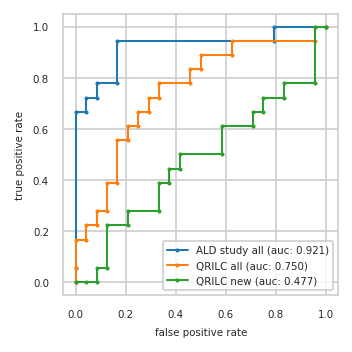

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.667     0.000 0.167     0.083 0.000
3          0.042 0.667     0.042 0.167     0.083 0.056
4          0.042 0.722     0.042 0.222     0.125 0.056
5          0.083 0.722     0.083 0.222     0.125 0.222
6          0.083 0.778     0.083 0.278     0.208 0.222
7          0.167 0.778     0.125 0.278     0.208 0.278
8          0.167 0.944     0.125 0.389     0.333 0.278
9          0.792 0.944     0.167 0.389     0.333 0.389
10         0.792 1.000     0.167 0.556     0.375 0.389
11         1.000 1.000     0.208 0.556     0.375 0.444
12           NaN   NaN     0.208 0.611     0.417 0.444
13           NaN   NaN     0.250 0.611     0.417 0.500
14           NaN   NaN     0.250 0.667     0.583 0.500
15           NaN   NaN     0.292 0.667     0.583 0.611
16           NaN   NaN     0.292 0.722     0.708 0.611
17           NaN   NaN     0.333 0.722     0.708 0.667
18           NaN   NaN     0.333 0.778     0.750 0.667
19           NaN   NaN     0.458 0.778     0.750 0.722
20           NaN   NaN     0.458 0.833     0.833 0.722
21           NaN   NaN     0.500 0.833     0.833 0.778
22           NaN   NaN     0.500 0.889     0.958 0.778
23           NaN   NaN     0.625 0.889     0.958 1.000
24           NaN   NaN     0.625 0.944     1.000 1.000
25           NaN   NaN     0.958 0.944       NaN   NaN
26           NaN   NaN     0.958 1.000       NaN   NaN
27           NaN   NaN     1.000 1.000       NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
1,Q8NBI6,P60709;P63261,None
2,P04114,P04430,None
3,P61981,P10636-2;P10636-6,None
4,P14174,P61981,None
5,P04075,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...,None
6,Q9Y2T3;Q9Y2T3-3,P04075,None
7,P00338;P00338-3,P14174,None
8,P63104,P00338;P00338-3,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


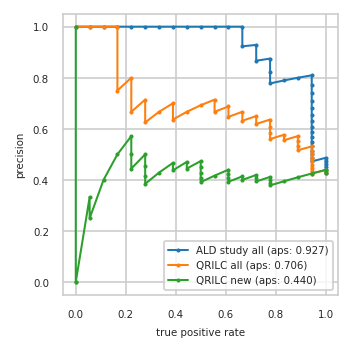

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.425 0.944     0.425 0.944
3          0.462 1.000     0.436 0.944     0.410 0.889
4          0.474 1.000     0.447 0.944     0.395 0.833
5          0.486 1.000     0.459 0.944     0.378 0.778
6          0.472 0.944     0.472 0.944     0.389 0.778
7          0.486 0.944     0.486 0.944     0.400 0.778
8          0.500 0.944     0.500 0.944     0.412 0.778
9          0.515 0.944     0.515 0.944     0.394 0.722
10         0.531 0.944     0.531 0.944     0.406 0.722
11         0.548 0.944     0.516 0.889     0.419 0.722
12         0.567 0.944     0.533 0.889     0.400 0.667
13         0.586 0.944     0.552 0.889     0.414 0.667
14         0.607 0.944     0.571 0.889     0.393 0.611
15         0.630 0.944     0.556 0.833     0.407 0.611
16         0.654 0.944     0.577 0.833     0.423 0.611
17         0.680 0.944     0.560 0.778     0.440 0.611
18         0.708 0.944     0.583 0.778     0.417 0.556
19         0.739 0.944     0.609 0.778     0.391 0.500
20         0.773 0.944     0.636 0.778     0.409 0.500
21         0.810 0.944     0.619 0.722     0.429 0.500
22         0.800 0.889     0.650 0.722     0.450 0.500
23         0.789 0.833     0.632 0.667     0.474 0.500
24         0.778 0.778     0.667 0.667     0.444 0.444
25         0.824 0.778     0.647 0.611     0.471 0.444
26         0.875 0.778     0.688 0.611     0.438 0.389
27         0.867 0.722     0.667 0.556     0.467 0.389
28         0.929 0.722     0.714 0.556     0.429 0.333
29         0.923 0.667     0.692 0.500     0.385 0.278
30         1.000 0.667     0.667 0.444     0.417 0.278
31         1.000 0.611     0.636 0.389     0.455 0.278
32         1.000 0.556     0.700 0.389     0.500 0.278
33         1.000 0.500     0.667 0.333     0.444 0.222
34         1.000 0.444     0.625 0.278     0.500 0.222
35         1.000 0.389     0.714 0.278     0.571 0.222
36         1.000 0.333     0.667 0.222     0.500 0.167
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


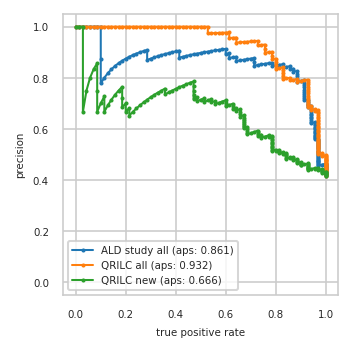

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


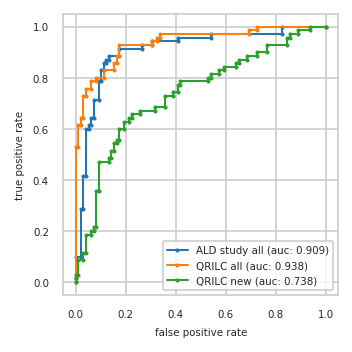

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}